In [1]:
# Notebook to compare basic meteorological parameters between WRF simulations and ERA5 data
# Some of the following imports are not used right now, but will retain for future flexibility
#import sys
#!{sys.executable} -m pip install geopandas
 
import os
import geopandas as gpd
from shapely.geometry import Point
import csv
import subprocess
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.cbook as cbook
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
from matplotlib.font_manager import FontProperties
import pandas as pd
import xarray as xr
import numpy as np
import math
from numpy import *
from pylab import *
import pygrib
import pyproj
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata
from siphon.catalog import TDSCatalog
from siphon.http_util import session_manager
from datetime import datetime, timedelta
from xarray.backends import NetCDF4DataStore
from netCDF4 import Dataset
import metpy as metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.units import units
from metpy.plots import add_metpy_logo, add_timestamp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy import config
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
import glob

In [2]:
titles = ['PRISM', 'Thompson', 'Thompson AA', 'WSM6', 'WDM6',
          'P3', 'P3 2X', 'P3 2nd', 'P3 3-mom', 'Ishmael', 'NTU']


In [3]:
# Load current file
wrf_file = "/scratch/sawyer/wwrf/2017-01-09/ctrl/wrfout_d02_2017-01-09_12:00:00"
datafiles = (glob.glob(wrf_file))
ncfile = Dataset(datafiles[0])
#lu_index = ncfile['LU_INDEX'][0,:,:]
#print(lu_index)
rainc = getvar(ncfile, "RAINC")
wrf_lats, wrf_lons = latlon_coords(rainc)
## WWRF longitude fix ######
new_lons =np.where(wrf_lons > 0, wrf_lons - 360, wrf_lons)

cart_proj = get_cartopy(rainc)

print('lon max: ', np.max(new_lons).item(),'\nlat max: ',
      np.max(wrf_lats).item(),'\nlon min: ', np.min(new_lons).item(),
      '\nlat min: ', np.min(wrf_lats).item())
lon_max = np.max(new_lons).item()
lon_min = np.min(new_lons).item()
lat_max = np.max(wrf_lats).item()
lat_min = np.min(wrf_lats).item()

lon max:  -113.37020874023438 
lat max:  43.04642105102539 
lon min:  -131.49412536621094 
lat min:  30.631916046142578


In [4]:
def compute_rain_total(current_file_path, initial_file_path):
    # Load current file
    
    current_datafiles = (glob.glob(current_file_path))
    ncfile_current = Dataset(current_datafiles[0])
    land_mask = ncfile_current['LANDMASK'][0,:,:]
    

    rainc_current = getvar(ncfile_current, "RAINC")
    rainnc_current = getvar(ncfile_current, "RAINNC")
    rain_final = (rainnc_current + rainc_current) * land_mask
    # Apply the land mask on rain data
  
    # Load initial file
    initial_datafiles = (glob.glob(initial_file_path))
    ncfile_initial = Dataset(initial_datafiles[0])
    rainc_initial = getvar(ncfile_initial, "RAINC")
    rainnc_initial = getvar(ncfile_initial, "RAINNC")
    rain_initial = (rainnc_initial + rainc_initial) * land_mask
    # Apply the land mask on rain data
 
    
    return rain_final - rain_initial

def rmse(predictions, targets):
    x = (predictions - targets) ** 2
    x_mean = np.nanmean(x)
    rmserror = np.sqrt(x_mean)
    return rmserror

In [5]:
thompson_final = "/scratch/sawyer/wwrf/2017-01-09/ctrl/wrfout_d02_2017-01-09_12:00:00"
thompson_init = "/scratch/sawyer/wwrf/2017-01-09/ctrl/wrfout_d02_2017-01-06_12:00:00"

wsm6_final = "/scratch/sawyer/wwrf/2017-01-09/wsm6/wrfout_d02_2017-01-09_12:00:00"
wsm6_init = "/scratch/sawyer/wwrf/2017-01-09/wsm6/wrfout_d02_2017-01-06_12:00:00"

wdm6_final = "/scratch/sawyer/wwrf/2017-01-09/wdm6/wrfout_d02_2017-01-09_12:00:00"
wdm6_init = "/scratch/sawyer/wwrf/2017-01-09/wdm6/wrfout_d02_2017-01-06_12:00:00"

ishmael_final = "/scratch/sawyer/wwrf/2017-01-09/ishmael/wrfout_d02_2017-01-09_12:00:00"
ishmael_init = "/scratch/sawyer/wwrf/2017-01-09/ishmael/wrfout_d02_2017-01-06_12:00:00"

p3_final = "/scratch/sawyer/wwrf/2017-01-09/p3_1-cat/wrfout_d02_2017-01-09_12:00:00"
p3_init = "/scratch/sawyer/wwrf/2017-01-09/p3_1-cat/wrfout_d02_2017-01-06_12:00:00"

p3_2x_final = "/scratch/sawyer/wwrf/2017-01-09/p3_2x_cloud/wrfout_d02_2017-01-09_12:00:00"
p3_2x_init = "/scratch/sawyer/wwrf/2017-01-09/p3_2x_cloud/wrfout_d02_2017-01-06_12:00:00"

p3_3mom_final = "/scratch/sawyer/wwrf/2017-01-09/p3_3mom/wrfout_d02_2017-01-09_12:00:00"
p3_3mom_init = "/scratch/sawyer/wwrf/2017-01-09/p3_3mom/wrfout_d02_2017-01-06_12:00:00"

p3_2nd_final = "/scratch/sawyer/wwrf/2017-01-09/p3_2nd/wrfout_d02_2017-01-09_12:00:00"
p3_2nd_init = "/scratch/sawyer/wwrf/2017-01-09/p3_2nd/wrfout_d02_2017-01-06_12:00:00"

thompson_aa_final = "/scratch/sawyer/wwrf/2017-01-09/thompson_aa_38/wrfout_d02_2017-01-09_12:00:00"
thompson_aa_init = "/scratch/sawyer/wwrf/2017-01-09/thompson_aa_38/wrfout_d02_2017-01-06_12:00:00"

ntu_final = "/scratch/sawyer/wwrf/2017-01-09/ntu/wrfout_d02_2017-01-09_12:00:00"
ntu_init = "/scratch/sawyer/wwrf/2017-01-09/ntu/wrfout_d02_2017-01-06_12:00:00"

In [6]:
thompson_storm_total = compute_rain_total(thompson_final,thompson_init)

thompson_aa_storm_total = compute_rain_total(thompson_aa_final,thompson_aa_init)

wsm6_storm_total = compute_rain_total(wsm6_final,wsm6_init)

wdm6_storm_total = compute_rain_total(wdm6_final,wdm6_init)

p3_storm_total = compute_rain_total(p3_final,p3_init)

p3_2x_storm_total = compute_rain_total(p3_2x_final,p3_2x_init)

p3_2nd_storm_total = compute_rain_total(p3_2nd_final,p3_2nd_init)

p3_3mom_storm_total = compute_rain_total(p3_3mom_final,p3_3mom_init)

ishamel_storm_total = compute_rain_total(ishmael_final,ishmael_init)

ntu_storm_total = compute_rain_total(ntu_final,ntu_init)
#print(thompson_storm_total.shape
print(ntu_storm_total.max())

<xarray.DataArray ()>
array(783.4796, dtype=float32)


In [7]:
prism ='/scratch/sawyer/2017_01_09/prism_2017_01_07.nc'
files = (glob.glob(prism))
file = Dataset(files[0])
# Extract data
lats = file.variables['lat'][:] 
# assuming the latitude variable is named 'latitude'
lons = file.variables['lon'][:]
precip = file.variables['Band1'][:]
print(lats.shape, lons.shape, precip.shape)
lon_prism, lat_prism = np.meshgrid(lons, lats)

# Create a mask for PRISM data based on WRF domain
wrf_domain_mask = ((lat_prism >= lat_max) & (lat_prism <= lat_max) & 
        (lon_prism >= lon_min) & (lon_prism <= lon_max))

# Prepare files for processing
prism_data = '/scratch/sawyer/2017_01_09/prism*'
datafiles = (glob.glob(prism_data))
datafiles.sort()
numfiles=len(datafiles)
print(datafiles)
#Add PRISM Storm Total
prism_storm_total = np.zeros(precip.shape)
for i in range(0,numfiles):

    ncfile = Dataset(datafiles[i])
    precip = ncfile.variables['Band1'][:]  # assuming the precipitation variable is named 'precip'
    # Add current precipitation data to total_precip
    # Apply the mask to the PRISM data

    prism_storm_total += precip
    #prism_storm_total += masked_prism
    




(621,) (1405,) (621, 1405)
['/scratch/sawyer/2017_01_09/prism_2017_01_07.nc', '/scratch/sawyer/2017_01_09/prism_2017_01_08.nc', '/scratch/sawyer/2017_01_09/prism_2017_01_09.nc']


In [8]:
wrf_precip = [thompson_storm_total,thompson_aa_storm_total,wsm6_storm_total,
            wdm6_storm_total,p3_storm_total,p3_2x_storm_total,p3_2nd_storm_total,
           p3_3mom_storm_total,ishamel_storm_total, ntu_storm_total]
# appending all the interpolated storm total 3 km wrf grids to a list with PRISM storm total
interp_list = [prism_storm_total]
for i in wrf_precip:
    # Define the source CRS (your PRISM data's original projection)
    target_proj = pyproj.Proj(proj='latlong', datum='NAD83', ellps='GRS80')

    # Define the target CRS as WGS 84
    source_proj = pyproj.Proj(proj="latlong", datum="WGS84")

    # Transform the PRISM coordinates
    lon_new, lat_new = pyproj.transform(source_proj, target_proj, new_lons,wrf_lats) #lon_prism, lat_prism)
    #print(lon_new)

    # Assuming wrf_lon and wrf_lat are the 2D arrays representing the longitude and latitude grids of your WRF data.
    points_wrf = (lon_new.ravel(), lat_new.ravel()) 
    #print(points_prism)# Reprojected PRISM coordinates
    values_prism = to_np(i).ravel()  # PRISM data values

    data_wrf = griddata(points_wrf, values_prism, (lon_prism, lat_prism), method='linear')
    interp_list.append(data_wrf)
print("Reprojected WRF Lon bounds:", lon_new.min(), "-", lon_new.max())
print("PRISM Lon bounds:", lon_prism.min(), "-", lon_prism.max())
print("Reprojected WRF Lat bounds:", lat_new.min(), "-", lat_new.max())
print("PRISM Lat bounds:", lat_prism.min(), "-", lat_prism.max())


/tmp/ipykernel_12365/1968600018.py:14: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_new, lat_new = pyproj.transform(source_proj, target_proj, new_lons,wrf_lats) #lon_prism, lat_prism)
/tmp/ipykernel_12365/1968600018.py:14: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_new, lat_new = pyproj.transform(source_proj, target_proj, new_lons,wrf_lats) #lon_prism, lat_prism)
/tmp/ipykernel_12365/1968600018.py:14: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_new, lat_new = pyproj.transform(source_proj, target_proj, new_lons,wrf_lats) #lon_prism, lat_prism)
/tmp/ipykernel_12365/1968600018.py:14: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-

Reprojected WRF Lon bounds: -131.49412536621094 - -113.37020874023438
PRISM Lon bounds: -125.0 - -66.4999999999532
Reprojected WRF Lat bounds: 30.631916046142578 - 43.04642105102539
PRISM Lat bounds: 24.083333333312403 - 49.9166666666664


In [9]:
# Create a mask for PRISM data based on WRF domain
wrf_domain_mask = ((lat_prism >= lat_max) & (lat_prism <= lat_max) & 
        (lon_prism >= lon_min) & (lon_prism <= lon_max))

masked_prism = np.where(wrf_domain_mask, prism_storm_total, np.nan)
print(np.nanmin(masked_prism))
'''
# Load US states shapefile
states = gpd.read_file('/scratch/sawyer/geopandas/ne_110m_admin_1_states_provinces.shp')

california = states[states.name == 'California']
#print(california)

def in_california_shape(lats, lons):
    """Check if coordinates are inside California's shape."""
    point = Point(lons, lats)
    return california.geometry.contains(point).values[0]

# Vectorize the function
vectorized_contains = np.vectorize(in_california_shape)

# Apply the vectorized function on the arrays
cali_prism = vectorized_contains(lat_prism, lon_prism)
'''

nan


/tmp/ipykernel_12365/3453036704.py:6: RuntimeWarning: All-NaN slice encountered
  print(np.nanmin(masked_prism))


'\n# Load US states shapefile\nstates = gpd.read_file(\'/scratch/sawyer/geopandas/ne_110m_admin_1_states_provinces.shp\')\n\ncalifornia = states[states.name == \'California\']\n#print(california)\n\ndef in_california_shape(lats, lons):\n    """Check if coordinates are inside California\'s shape."""\n    point = Point(lons, lats)\n    return california.geometry.contains(point).values[0]\n\n# Vectorize the function\nvectorized_contains = np.vectorize(in_california_shape)\n\n# Apply the vectorized function on the arrays\ncali_prism = vectorized_contains(lat_prism, lon_prism)\n'

In [10]:
# Insert the PRISM storm total as the first element
print(len(interp_list))
prism_data = interp_list[0]

# PRISM has -9999 Values, so replacing those with NAN below
#mask = prism_storm_total > 0
#prism_inter = np.where(mask, prism_data, np.nan)

# Only indexing the WRF storm totals in interp_list
wrf_precip = interp_list[1:]

11


/tmp/ipykernel_12365/730979969.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


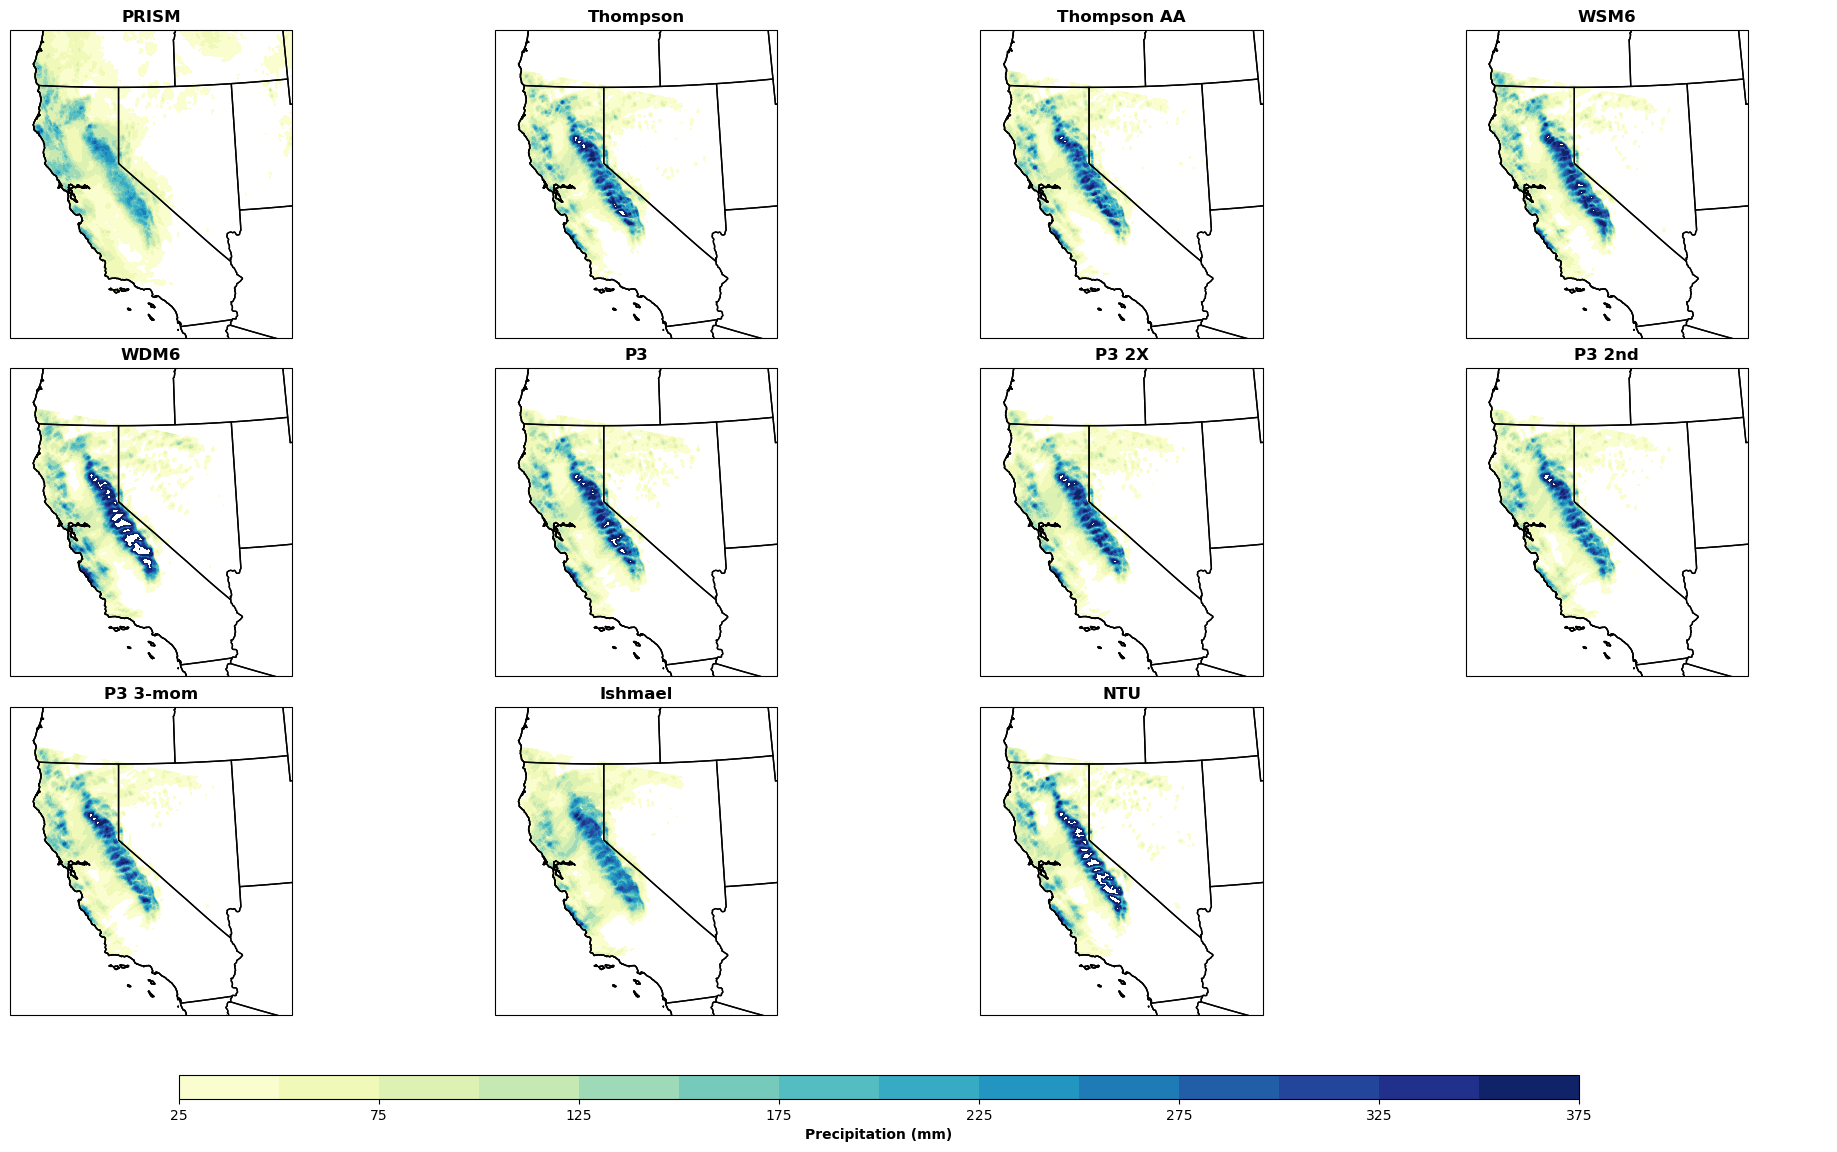

In [11]:
font_bold = FontProperties()
font_bold.set_weight('bold')
# Create 10 subplots
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 12),
                        subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-120)})
axs = axs.ravel()  # Flatten axs to loop over
# Gridlines' latitudes and longitudes
lats = np.arange(32, 43, 2)  # Example: ticks every 2 degrees. Adjust as needed.
lons = np.arange(-125, -114, 2)
for i, ax in enumerate(axs[:-1]):
    #print(titles[i])
    ax.set_extent([-125,-112,32,44])
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0, edgecolor='black')  # Add coastlines
    ax.add_feature(cfeature.STATES, linewidth=1.0, edgecolor='black')
    # Use gridlines and customize them to look like ticks
    #gl = ax.gridlines(draw_labels=False, linewidth=1, color='black', alpha=0.5, linestyle='--', xlocs=lons, ylocs=lats)
    #gl.xlabels_bottom = True
    #gl.ylabels_left = True
    #gl.xlines = True
    #gl.ylines = True
    #gl.linewidth = .5
    #gl.color = 'black'

    # Set the title for each subplot
    ax.set_title(titles[i], fontweight='bold')
    # Plot filled contour
    cp = ax.contourf(lon_prism, lat_prism, interp_list[i], cmap='YlGnBu', 
                     levels=np.arange(25, 400, 25), transform=ccrs.PlateCarree())
    ax.coastlines()
# Turn off the last subplot
axs[-1].axis('off')
# Add a single colorbar at the bottom of the figure
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Adjust these dimensions to fit the colorbar nicely
cbar = fig.colorbar(cp, cax=cbar_ax, orientation='horizontal', label="Precipitation (mm)")
cbar.set_label("Precipitation (mm)", fontproperties=font_bold)
# Adjust layout
fig.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the colorbar

plt.savefig('StormTotal_QPF')
plt.show()

In [12]:
diff_fields = []
for precip_value in wrf_precip:
    # Compute the difference
    diff_fields.append(prism_inter - precip_value)
print(diff_fields[0].shape)

#for i in diff_fields:
    #print(np.nanmin(i))

NameError: name 'prism_inter' is not defined

In [ ]:
prism_sum = np.nanmean(prism_inter)
print(prism_sum)
bias_errors = []
for precip_data in wrf_precip:
    
    total = np.nanmean(precip_data)
    bias = round((total-prism_sum),2)
    bias_errors.append(bias)
    #print(total)
    #print('bias: ', bias)


In [ ]:

#mse = mean_squared_error(data_wrf, thompson_storm_total)
#rmsee = np.sqrt(mse)

rain_errors = []
for precip_data in wrf_precip:
    errors = rmse(precip_data,prism_inter)
    rain_errors.append(round(errors,2))
  
wrf_titles = ['Thompson', 'Thompson AA', 'WSM6', 'WDM6',
          'P3', 'P3 2X', 'P3 2nd', 'P3 3-mom', 'Ishmael', 'NTU']


In [ ]:
#print(rain_errors)

In [ ]:
# Create 10 subplots
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 12),
                        subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-120)})
axs = axs.ravel()  # Flatten axs to loop over
# Gridlines' latitudes and longitudes
lats = np.arange(32, 43, 2)  # Example: ticks every 2 degrees. Adjust as needed.
lons = np.arange(-125, -114, 2)
#levels = np.arange(-200,200,50)
levels = np.arange(-400, 200, 25)

norm = TwoSlopeNorm(vmin=levels.min(), vcenter=0, vmax=levels.max())  # This normalizes the colormap around 0
for i, ax in enumerate(axs):
    #print(titles[i])
    ax.set_extent([-125,-112,32,44])
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')  # Add coastlines
    ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='black')
    # Use gridlines and customize them to look like ticks
    #gl = ax.gridlines(draw_labels=False, linewidth=1, color='black', alpha=0.5, linestyle='--', xlocs=lons, ylocs=lats)
    #gl.xlabels_bottom = True
    #gl.ylabels_left = True
    #gl.xlines = True
    #gl.ylines = True
    #gl.linewidth = .5
    #gl.color = 'black'

    # Set the title for each subplot
    ax.set_title(f"{wrf_titles[i]} \nRMSE = {rain_errors[i]} mm\nBias = {bias_errors[i]} mm", fontweight='bold', fontsize=14,loc='left')
    #ax.set_title(f"RMSE = {rain_errors[i]} mm", fontweight='bold',fontsize=10, loc='right')
    # Plot filled contour
    cp = ax.contourf(lon_prism, lat_prism, diff_fields[i],levels=levels, cmap='RdBu', norm=norm,transform=ccrs.PlateCarree())
    ax.coastlines()
    

# Add a single colorbar at the bottom of the figure
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Adjust these dimensions to fit the colorbar nicely
cbar = fig.colorbar(cp, cax=cbar_ax, orientation='horizontal', label="Precipitation (mm)")
# Set the ticks explicitly
cbar.set_ticks(levels)
#cbar.set_label(fontproperties=font_bold)
# Adjust layout
fig.tight_layout()
plt.subplots_adjust(bottom=0.15, hspace=0.3)  # Make space for the colorbar

plt.savefig('StormTotal_Diff_Fields_QPF')
plt.show()

In [ ]:
from scipy.stats import pearsonr
prism = to_np(cali_wrf_and_prism_precip[0])
wrf = to_np(cali_wrf_and_prism_precip[1:])
#valid_indices = ~np.isnan(prism) & ~np.isnan(wrf)
corr = []
corr_sqrd = []
for i in wrf:
    # Calculate valid indices for the current pair
    valid_indices = ~np.isnan(prism) & ~np.isnan(i)
    
    correlation_coefficient, _ = pearsonr(i[valid_indices], prism[valid_indices])
    corr_sq = correlation_coefficient**2
    corr_sqrd.append(round(corr_sq,4))
    correlation_coefficient = round(correlation_coefficient,4)
    #print(correlation_coefficient)
    corr.append(correlation_coefficient)
print(corr_sqrd)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 12))
axs = axs.ravel()

corr = []
corr_sqrd = []

for i, ax in enumerate(axs):
    current_wrf_data = wrf[i]
    
    valid_indices = ~np.isnan(prism) & ~np.isnan(current_wrf_data)
    filtered_prism = np.array(prism)[valid_indices]
    filtered_wrf_data = np.array(current_wrf_data)[valid_indices]

    # Scatter plot
    ax.scatter(filtered_prism, filtered_wrf_data, alpha=0.5, label='Data')

    # Line of best fit
    slope, intercept = np.polyfit(filtered_prism, filtered_wrf_data, 1)
    ax.plot(filtered_prism, slope*filtered_prism + intercept, color='red', label=f'Fit: y={slope:.2f}x + {intercept:.2f}')

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = pearsonr(filtered_prism, filtered_wrf_data)
    corr.append(correlation_coefficient)
    corr_sqrd.append(correlation_coefficient**2)
    
    # Add legend entry for correlation coefficient and r^2
    #ax.legend([f'Corr: {correlation_coefficient:.2f}', f'$r^2$: {correlation_coefficient**2:.2f}'])
    #ax.legend([f'Corr: {correlation_coefficient:.2f}', f'$r^2$: {correlation_coefficient**2:.2f}'], fontsize=13,loc='upper left')
    # Add text for correlation coefficient and r^2 in the upper left corner
    ax.text(0.05, 0.95, f'CORR: {correlation_coefficient:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=14,fontweight='bold')
    ax.text(0.05, 0.88, f'$r^2$: {correlation_coefficient**2:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=14,fontweight='bold')
   # Add labels 
    ax.set_xlabel('PRISM', fontsize = 14,fontweight='bold')
    ax.set_ylabel(f'{wrf_titles[i]}', fontsize = 14,fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# Create 10 subplots
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 12),
                        subplot_kw={'projection': ccrs.LambertConformal()})
axs = axs.ravel()  # Flatten axs to loop over
# Gridlines' latitudes and longitudes
lats = np.arange(32, 43, 2)  # Example: ticks every 2 degrees. Adjust as needed.
lons = np.arange(-125, -114, 2)
#levels = np.arange(-200,200,50)
levels = np.arange(-400, 200, 25)

norm = TwoSlopeNorm(vmin=levels.min(), vcenter=0, vmax=levels.max())  # This normalizes the colormap around 0
for i, ax in enumerate(axs):
    #print(titles[i])
    ax.set_extent([-125,-115,32,42])
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')  # Add coastlines
    ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='black')
    # Use gridlines and customize them to look like ticks
    #gl = ax.gridlines(draw_labels=False, linewidth=1, color='black', alpha=0.5, linestyle='--', xlocs=lons, ylocs=lats)
    #gl.xlabels_bottom = True
    #gl.ylabels_left = True
    #gl.xlines = True
    #gl.ylines = True
    #gl.linewidth = .5
    #gl.color = 'black'

    # Set the title for each subplot
    ax.set_title(f"{wrf_titles[i]} \nRMSE = {rain_errors[i]} mm\nBias = {bias_errors[i]} mm", fontweight='bold', fontsize=14,loc='left')

    

# Add a single colorbar at the bottom of the figure
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Adjust these dimensions to fit the colorbar nicely
cbar = fig.colorbar(cp, cax=cbar_ax, orientation='horizontal', label="Precipitation (mm)")
# Set the ticks explicitly
cbar.set_ticks(levels)
#cbar.set_label(fontproperties=font_bold)
# Adjust layout
fig.tight_layout()
plt.subplots_adjust(bottom=0.15, hspace=0.3)  # Make space for the colorbar

plt.savefig('StormTotal_Diff_Fields_QPF')
plt.show()

In [ ]:
# Set up the map projection and figure

projection=ccrs.LambertConformal()
fig, ax = plt.subplots(figsize=(10, 6),subplot_kw={'projection': projection})
ax.set_extent([-125, -90, 30, 45])
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='black')
ax.coastlines('50m', linewidth=0.6, color='black')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False   # suppress top grid labels
gl.right_labels=False # suppress right grid labels

levels=np.arange(1,400,50)
# Plot the interpolated data on the WRF grid
plt.contourf(lon_prism, lat_prism, interp_list[1],levels = levels, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
plt.colorbar(label='Precipitation')

# Add title and show plot
plt.title("Interpolated PRISM Data on WRF Grid")
plt.show()

In [ ]:
# Set up the map projection and figure

projection=ccrs.LambertConformal()
fig, ax = plt.subplots(figsize=(10, 6),subplot_kw={'projection': projection})
ax.set_extent([-125, -110, 33, 42])
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='black')
ax.coastlines('50m', linewidth=0.6, color='black')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False   # suppress top grid labels
gl.right_labels=False # suppress right grid labels


# Plot the interpolated data on the WRF grid
plt.contourf(wrf_lons, wrf_lats, rain,levels=levels, cmap='Blues', transform=ccrs.PlateCarree())

# Add a colorbar
plt.colorbar(label='Precipitation')

# Add title and show plot
plt.title("WRF Rain")
plt.show()

In [ ]:
difference_fields = prism_inter - rain

In [ ]:
# Set up the map projection and figure

projection=ccrs.LambertConformal()
fig, ax = plt.subplots(figsize=(10, 6),subplot_kw={'projection': projection})
ax.set_extent([-125, -110, 33, 42])
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='black')
ax.coastlines('50m', linewidth=0.6, color='black')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False   # suppress top grid labels
gl.right_labels=False # suppress right grid labels

diff_lvl = np.arange(-60,80,10)
# Plot the interpolated data on the WRF grid
plt.contourf(wrf_lons, wrf_lats, difference_fields,levels=diff_lvl, cmap='RdBu', transform=ccrs.PlateCarree())

# Add a colorbar
plt.colorbar(label='Precipitation')

# Add title and show plot
plt.title("PRISM - WRF Priciptation valid ")
plt.show()

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [ ]:
rmse = rmse(rain, prism_inter)

In [ ]:
print(rmse)

In [ ]:
'''

# Define the CSV file path
csv_file_path = "your_data.csv"

# Sample data as a list of dictionaries
data = [
    {"Ensemble member": 'NTU', "Day 1 RMSE": 6.48, "Day 2 RMSE": 0.6, "Day 3 RMSE": 0.7, "Storm Total RMSE": 2.0},
    {"Ensemble member": 'Thompson, "Day 1 RMSE": 4.76, "Day 2 RMSE": 0.7, "Day 3 RMSE": 0.8, "Storm Total RMSE": 2.1},
    {"Ensemble member": 'WSM6, "Day 1 RMSE": 5.67, "Day 2 RMSE": 0.7, "Day 3 RMSE": 0.8, "Storm Total RMSE": 2.1},# Add more data for other ensemble members
{"Ensemble member": 'WDM6, "Day 1 RMSE": 6.78, "Day 2 RMSE": 0.7, "Day 3 RMSE": 0.8, "Storm Total RMSE": 2.1},
{"Ensemble member": 'P3, "Day 1 RMSE": 5.12, "Day 2 RMSE": 0.7, "Day 3 RMSE": 0.8, "Storm Total RMSE": 2.1},
{"Ensemble member": 'P3 2nd , "Day 1 RMSE": 4.81, "Day 2 RMSE": 0.7, "Day 3 RMSE": 0.8, "Storm Total RMSE": 2.1},
{"Ensemble member": 'Ishmael, "Day 1 RMSE": 5.46, "Day 2 RMSE": 0.7, "Day 3 RMSE": 0.8, "Storm Total RMSE": 2.1},
{"Ensemble member": 'Thompson AA, "Day 1 RMSE": 4.72, "Day 2 RMSE": 0.7, "Day 3 RMSE": 0.8, "Storm Total RMSE": 2.1},
{"Ensemble member": 'P3 2x Cloud, "Day 1 RMSE": 4.76, "Day 2 RMSE": 0.7, "Day 3 RMSE": 0.8, "Storm Total RMSE": 2.1},
{"Ensemble member": 'P3 3mom, "Day 1 RMSE": 4.76, "Day 2 RMSE": 0.7, "Day 3 RMSE": 0.8, "Storm Total RMSE": 2.1},]

# Check if the CSV file already exists
file_exists = False
try:
    with open(csv_file_path, "r") as file:
        # If the file exists, read it to check for existing data
        file_exists = True
except FileNotFoundError:
    pass

# Open the CSV file in append mode
with open(csv_file_path, "a", newline="") as file:
    fieldnames = ["Ensemble member", "Day 1 RMSE", "Day 2 RMSE", "Day 3 RMSE", "Storm Total RMSE"]
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    
    # Write the header row if the file is newly created
    if not file_exists:
        writer.writeheader()
    
    # Write data for each ensemble member
    for row in data:
        writer.writerow(row)

print("Data has been appended to the CSV file.")
'''

In [ ]:
# Set up the map projection and figure

projection=ccrs.LambertConformal()
fig, ax = plt.subplots(figsize=(10, 6),subplot_kw={'projection': projection})
ax.set_extent([-125, -110, 33, 42])
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='black')
ax.coastlines('50m', linewidth=0.6, color='black')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False   # suppress top grid labels
gl.right_labels=False # suppress right grid labels

diff_lvl = np.arange(0,100,2)
# Plot the interpolated data on the WRF grid
plt.contourf(wrf_lons, wrf_lats, root_errors,levels=diff_lvl, cmap='Blues', transform=ccrs.PlateCarree())

# Add a colorbar
plt.colorbar(label='Precipitation')

# Add title and show plot
plt.title("WRF Rain")
plt.show()

In [ ]:
'''
# Create masked arrays with NaN values
#masked_predicted = np.ma.masked_invalid(rain)
#masked_true = np.ma.masked_invalid(prism_inter)
mask = rain != nan

rain_mask = np.ma.array(rain, mask=~mask)
print(rain_mask)
pism_mask = prism_inter!=nan
prism_mask = np.ma.array(prism_inter, mask=~pism_mask)

# Calculate Pearson's correlation coefficient
correlation_matrix = np.corrcoef(rain_mask, prism_mask)
pearson_corr_coefficient = correlation_matrix[0, 1]
print(pearson_corr_coefficient)
# Calculate Pearson's correlation coefficient
#correlation_coefficient = np.ma.corrcoef(masked_predicted, masked_true)[0, 1]

#print(f"Pearson's correlation coefficient (r): {correlation_coefficient}")
'''